# Similar Players Components and Scouter AI Components - design and evaluation

In [1]:
# used libraries 
import json
import pandas as pd
import matplotlib.pyplot as plt

# Similar Player Component used libraries 
from sklearn.metrics.pairwise import cosine_similarity # Cosine Similarity
from sklearn.cluster import KMeans # Kmeans clustering

# evaluation
from sklearn.metrics import silhouette_score
from scipy.stats import spearmanr
from scipy.stats import kendalltau

# Scouter AI Component used libraries
import os 
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import AIMessage, HumanMessage, SystemMessage

# evaluation
from rouge_score import rouge_scorer
from bert_score import score

### Handling Apache Solr

In [2]:
from SolrClient import SolrClient
solr = SolrClient('http://localhost:8983/solr')

In [3]:
# retrieve data from Solr
res = solr.query('FootballStatsCore', {
    'q': '*:*',
    'fl': '*',
    'rows': 100000,
})
result = res.docs

if(result == []):
    print("There are no players")
    print(result)

In [4]:
# convert json result in dataframe
df_player = pd.DataFrame(result)

# Get the list of columns from the JSON result
columns_to_process = list(df_player.columns)

# Process the columns in the DataFrame
for column in columns_to_process:
    if isinstance(df_player[column][0], (list, dict)):
        df_player[column] = df_player[column].apply(lambda x: x[0] if isinstance(x, list) else (x if isinstance(x, dict) else x))

In [5]:
# delete non-interested columns
columns_to_drop = ['id','_version_']
df_player = df_player.drop(columns=columns_to_drop)

df_player

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,Int,Clr,...,GCA_GCA,Aerial_Duels_Won,Aerial_Duels_Lost,Aerial_Duels_Won_,Total_Cmp,Total_Att,Total_Cmp_,Total_TotDist,Total_PrgDist,1_3
0,0,Brenden Aaronson,USA,"MF,FW",Leeds United,Premier League,23,2000,5,6,...,7,8,39,17.0,592,797,74.3,7577,2182,47
1,1,Paxten Aaronson,USA,"MF,DF",Eint Frankfurt,Bundesliga,20,2003,0,2,...,2,1,1,50.0,51,71,71.8,659,109,3
2,2,James Abankwah,IRL,DF,Udinese,Serie A,19,2004,0,5,...,0,2,0,100.0,23,29,79.3,375,79,0
3,3,George Abbott,ENG,MF,Tottenham,Premier League,18,2005,1,0,...,0,0,0,0.0,1,1,100.0,8,0,0
4,4,Yunis Abdelhamid,MAR,DF,Reims,Ligue 1,36,1987,64,116,...,7,93,51,64.6,1679,2031,82.7,32967,13407,155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2717,2717,Martín Zubimendi,ESP,MF,Real Sociedad,La Liga,24,1999,37,55,...,6,58,34,63.0,1545,1812,85.3,26783,8092,175
2718,2718,Szymon Żurkowski,POL,MF,"Fiorentina, Spezia",Serie A,26,1997,4,6,...,1,7,11,87.5,87,120,158.8,1282,294,10
2719,2719,Martin Ødegaard,NOR,MF,Arsenal,Premier League,25,1998,6,12,...,17,13,20,39.4,1449,1804,80.3,22540,6014,135
2720,2720,Milan Đurić,BIH,FW,Hellas Verona,Serie A,33,1990,1,24,...,2,197,57,77.6,268,523,51.2,3119,740,27


##### Simple Search Engine Players for Evaluation

In [6]:
# Insert name of the player
player = 'Haaland'

In [7]:
res_p = solr.query('FootballStatsCore', {
    'q': 'Player:'+'*'+player+'*',
    'fl': 'Rk,Player',
})
result_p = res_p.docs

if(result_p == []):
    print("There are no Players")
    print(result)

In [8]:
# Process result
df_p = pd.DataFrame(result_p)
df_p['Rk'] = df_p['Rk'].apply(lambda x: x[0])
df_p['Player'] = df_p['Player'].apply(lambda x: x[0])
index_player = df_p['Rk'].values[0]
player_n = df_p['Player'].values[0]
df_p

,Rk,Player
0,1069,Erling Haaland


## Similar Player Component - Design and Evaluation
The workflow highlights the steps involved in developing the "Similar Players" component. Notably, it emphasizes the evaluation of algorithms to determine the most suitable one. If the evaluation results do not meet expectations, adjustments are made to the feature selection during the data preparation phase of the component. This iterative process ensures that the chosen algorithm aligns with the desired outcomes, optimizing the "Similar Players" functionality for player analysis.

In [9]:
# duplicate dataset because one of them needs to be normalised
df_player_norm = df_player.copy()

### Data Preparation for Algorithms used

##### Categorization with number 

In [10]:
custom_mapping = {
    'GK': 1,
    'DF,FW': 4,
    'MF,FW': 8,
    'DF': 2,
    'DF,MF': 3,
    'MF,DF': 5,
    'MF': 6,
    'FW,DF': 7,
    'FW,MF': 9,
    'FW': 10
}

# Apply custom mapping to the 'Pos' column
df_player_norm['Pos'] = df_player_norm['Pos'].map(custom_mapping)

#### Feature selection
The columns that can be normalised and are the best in the evaluation of the chosen algorithm are selected.

In [11]:
selected_features = ['Pos', 'Age', 'Int', 'Clr', 'KP', 'PPA', 'CrsPA', 'PrgP', 'Playing_Time_MP',
       'Performance_Gls', 'Performance_Ast', 'Performance_G_A',
       'Performance_G-PK', 'Performance_Fls', 'Performance_Fld',
       'Performance_Crs','Performance_Recov', 'Expected_xG', 'Expected_npxG', 'Expected_xAG',
       'Expected_xA', 'Expected_A-xAG', 'Expected_G-xG', 'Expected_np_G-xG',
       'Progression_PrgC', 'Progression_PrgP', 'Progression_PrgR',
       'Tackles_Tkl', 'Tackles_TklW', 'Tackles_Def_3rd', 'Tackles_Mid_3rd',
       'Tackles_Att_3rd', 'Challenges_Att', 'Challenges_Tkl_',
       'Challenges_Lost', 'Blocks_Blocks', 'Blocks_Sh', 'Blocks_Pass',
       'Standard_Sh', 'Standard_SoT','Standard_SoT_', 'Standard_Sh_90', 'Standard_Dist', 'Standard_FK',
       'Performance_GA', 'Performance_SoTA', 'Performance_Saves',
       'Performance_Save_', 'Performance_CS', 'Performance_CS_',
       'Penalty_Kicks_PKatt', 'Penalty_Kicks_Save_', 'SCA_SCA',
       'GCA_GCA', 'Aerial_Duels_Won', 'Aerial_Duels_Lost', 'Aerial_Duels_Won_',
       'Total_Cmp', 'Total_Att', 'Total_Cmp_', 'Total_TotDist',
       'Total_PrgDist', '1_3'
]

#### Normalization - MinMaxScaler

$X_{\text{norm}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}$

Where:
- $X_{norm}$ is the normalised value of the feature.
- $X$ is the original value of the feature.
- $X_{min}$ is the minimum value of the feature in the entire data set.
- $X_{max}$ is the maximum value of the feature in the entire data set.

This formula is used to normalize a feature so that the normalized values fall between 0 and 1 while preserving the relative proportions between the original values of the feature.

In [12]:
# Apply MinMaxScaler normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_player_norm[selected_features] = scaler.fit_transform(df_player_norm[selected_features])

## Cosine Similarity

In [13]:
similarity = cosine_similarity(df_player_norm[selected_features])
similarity.shape

(2722, 2722)

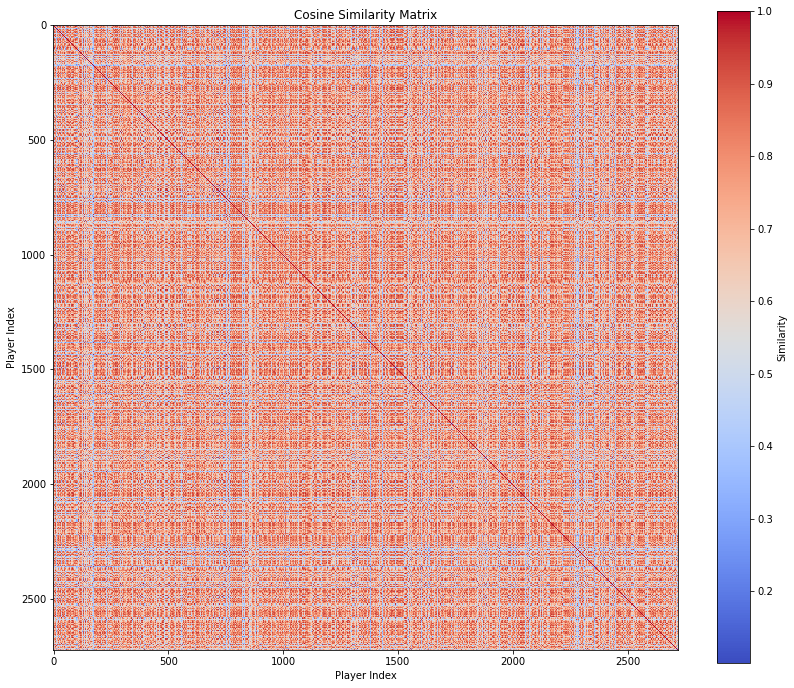

In [14]:
# Plot Cosine Similarity Matrix

plt.figure(figsize=(14, 12))
plt.imshow(similarity, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Similarity')
plt.title('Cosine Similarity Matrix')
plt.xlabel('Player Index')
plt.ylabel('Player Index')
plt.show()

In [15]:
# The result is then converted into a list of tuples, where each tuple contains two elements: 
# the index of the element in the original list and the similarity score between the specific element and that element.
similarity_score = list(enumerate(similarity[index_player]))

In [16]:
# Sort in descending order
similar_players = sorted(similarity_score, key=lambda x:x[1], reverse=True)
print(similar_players)

[(1069, 1.0000000000000004), (1892, 0.9742098194948069), (1882, 0.9636181172312804), (2644, 0.9466697249948539), (2608, 0.9425216775916614), (1596, 0.9347620457273761), (1278, 0.9297998956543237), (269, 0.9280559452744918), (1446, 0.9268133634692299), (1828, 0.9245456895425354), (2085, 0.908648878473492), (2620, 0.9077148892511677), (1635, 0.9073669119721339), (678, 0.9065082005337831), (626, 0.9064270608196213), (1379, 0.9028341197430514), (1200, 0.9005329137392468), (1736, 0.8986663073548875), (1174, 0.8983001919523989), (608, 0.8975534710478983), (2468, 0.8951304460767521), (686, 0.8936285981716565), (1331, 0.8902944318469014), (1719, 0.8851679976211011), (467, 0.8844350372515933), (2225, 0.8833950233819996), (1419, 0.883024071170498), (911, 0.8806939524908973), (2597, 0.8805554646813198), (1165, 0.8799584763569349), (2487, 0.8793541130307424), (1501, 0.8792623917277812), (1476, 0.8784688021090801), (1713, 0.8752547900411414), (976, 0.874407727991379), (2632, 0.8736351674681878), (9

In [17]:
# Creating a list to store the data of similar players
similar_players_data = []

# Cycle to extract information from similar players
for player in similar_players[1:11]:
    index = player[0]
    player_records = df_player[df_player['Rk'] == index]
    if not player_records.empty:
        player_data = player_records.iloc[0] 
        similar_players_data.append(player_data)

# Creating a DataFrame from the data of similar players
similar_players_df = pd.DataFrame(similar_players_data)

similar_players_df

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,Int,Clr,...,GCA_GCA,Aerial_Duels_Won,Aerial_Duels_Lost,Aerial_Duels_Won_,Total_Cmp,Total_Att,Total_Cmp_,Total_TotDist,Total_PrgDist,1_3
1892,1892,Victor Osimhen,NGA,FW,Napoli,Serie A,25,1998,6,29,...,9,65,54,54.6,276,400,69.0,3890,582,20
1882,1882,Loïs Openda,BEL,FW,Lens,Ligue 1,23,2000,2,6,...,12,13,20,39.4,297,443,67.0,4347,944,18
2644,2644,Callum Wilson,ENG,FW,Newcastle Utd,Premier League,31,1992,1,5,...,10,21,48,30.4,160,242,66.1,1996,339,10
2608,2608,Elye Wahi,FRA,FW,Montpellier,Ligue 1,20,2003,3,5,...,12,20,78,20.4,299,440,68.0,3580,635,17
1596,1596,Lautaro Martínez,ARG,FW,Inter,Serie A,26,1997,13,16,...,16,40,42,48.8,503,681,73.9,7435,1886,39
1278,1278,Harry Kane,ENG,FW,Tottenham,Premier League,30,1993,2,18,...,18,66,81,44.9,642,921,69.7,12295,4345,100
269,269,Wissam Ben Yedder,FRA,FW,Monaco,Ligue 1,33,1990,4,0,...,13,15,27,35.7,449,605,74.2,6103,1335,32
1446,1446,Robert Lewandowski,POL,FW,Barcelona,La Liga,35,1988,2,14,...,16,52,45,53.6,602,793,75.9,8306,1669,49
1828,1828,Christopher Nkunku,FRA,"FW,MF",RB Leipzig,Bundesliga,26,1997,8,11,...,14,17,26,39.5,497,620,80.2,7415,1852,35
2085,2085,Marcus Rashford,ENG,FW,Manchester Utd,Premier League,26,1997,7,14,...,14,20,40,33.3,627,817,76.7,8886,2180,38


##### Evaluation with Rank Correlation Coefficient
- Spearman
- Kendall Tau

In [18]:
# References from FBRef - https://fbref.com/en
similar_reference_player_1 = [23,1541,1592, 679,2147,1712,517, 878, 1405, 2490] # Leao Reference Rank
similar_reference_player_2 = [1736,686,1882,199, 2644,2620,1719, 1446,1069, 1827 ] # Osimhen Reference Rank
similar_reference_player_3 = [2644, 2597,1882,1446,1396, 1719, 199, 2468, 1051, 2620] # Haaland Reference Rank

In [19]:
# Calculate the coefficient of Kendall Tau and Spearman between the two ranking sets
spearman, _ = spearmanr(similar_players_df['Rk'].values, similar_reference_player_3) # Haaland Reference
kendall_tau, _ = kendalltau(similar_players_df['Rk'].values, similar_reference_player_3) # Haaland Reference

print(f"Coefficiente di Spearman tra i due ranking: {spearman}")
print(f"Coefficiente di Kendall Tau tra i due ranking: {kendall_tau}")

Coefficiente di Spearman tra i due ranking: 0.4545454545454545
Coefficiente di Kendall Tau tra i due ranking: 0.3333333333333333


### Kmeans Clustering



##### Elbow method for select best K values

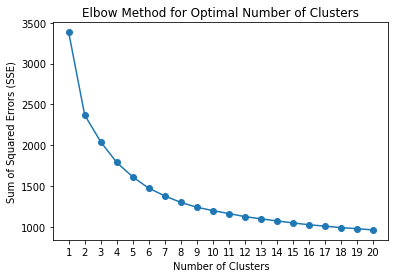

In [20]:
# Calculation of SSE (inertia) for different cluster values
sse_values = []
possible_clusters = range(1, 21)  # test with range of 20 clusters

for num_clusters in possible_clusters:
    kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans_model.fit(df_player_norm[selected_features])
    sse_values.append(kmeans_model.inertia_)

# Visualisation of SSE trend
plt.plot(possible_clusters, sse_values, marker='o')
plt.xticks(possible_clusters, possible_clusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

In [21]:
# Specifies the desired number of clusters
num_clusters = 4

# Create an instance of the K-Means model
kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)

# Train the model on player features
kmeans_model.fit(df_player_norm[selected_features])

# Get the cluster labels assigned to players
cluster_labels = kmeans_model.labels_

# Add cluster labels to the player dataframe
df_player_norm['Cluster'] = cluster_labels

#### Silhouette Score for validation

In [22]:
from sklearn.metrics import silhouette_score
print(f'Silhouette Score(n=4): {silhouette_score(df_player_norm[selected_features], cluster_labels)}')

Silhouette Score(n=4): 0.274574188555236


In [23]:
# Select the player of interest (target)
target_player = df_player_norm[df_player_norm['Rk'] == index_player]
target_features = target_player[selected_features]
target_cluster = target_player['Cluster'].iloc[0]  # Get the cluster label of the target player

# Filter the dataframe for players in the same cluster as the target player
similar_players_cluster_df = df_player_norm[df_player_norm['Cluster'] == target_cluster].copy()

# Calculate cosine similarity between the target player and other players in the same cluster
similarities = cosine_similarity(target_features, similar_players_cluster_df[selected_features])
similarities = similarities[0] * 100

# Add the 'Similarity' column to the dataframe using .loc
similar_players_cluster_df.loc[:, 'Similarity'] = similarities

# Sort the DataFrame based on the 'Similarity' column in descending order
similar_players_cluster_df = similar_players_cluster_df.sort_values(by='Similarity', ascending=False)

# Select from the second to the 11th element (remembering that indexing starts from 0)
similar_players_cluster_df = similar_players_cluster_df.iloc[1:11]

# Retrieve the non-normalized data from the original dataframe
similar_players_cluster_df = df_player[df_player['Rk'].isin(similar_players_cluster_df['Rk'])]

similar_players_cluster_df


,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,Int,Clr,...,GCA_GCA,Aerial_Duels_Won,Aerial_Duels_Lost,Aerial_Duels_Won_,Total_Cmp,Total_Att,Total_Cmp_,Total_TotDist,Total_PrgDist,1_3
269,269,Wissam Ben Yedder,FRA,FW,Monaco,Ligue 1,33,1990,4,0,...,13,15,27,35.7,449,605,74.2,6103,1335,32
1278,1278,Harry Kane,ENG,FW,Tottenham,Premier League,30,1993,2,18,...,18,66,81,44.9,642,921,69.7,12295,4345,100
1446,1446,Robert Lewandowski,POL,FW,Barcelona,La Liga,35,1988,2,14,...,16,52,45,53.6,602,793,75.9,8306,1669,49
1596,1596,Lautaro Martínez,ARG,FW,Inter,Serie A,26,1997,13,16,...,16,40,42,48.8,503,681,73.9,7435,1886,39
1828,1828,Christopher Nkunku,FRA,"FW,MF",RB Leipzig,Bundesliga,26,1997,8,11,...,14,17,26,39.5,497,620,80.2,7415,1852,35
1882,1882,Loïs Openda,BEL,FW,Lens,Ligue 1,23,2000,2,6,...,12,13,20,39.4,297,443,67.0,4347,944,18
1892,1892,Victor Osimhen,NGA,FW,Napoli,Serie A,25,1998,6,29,...,9,65,54,54.6,276,400,69.0,3890,582,20
2085,2085,Marcus Rashford,ENG,FW,Manchester Utd,Premier League,26,1997,7,14,...,14,20,40,33.3,627,817,76.7,8886,2180,38
2608,2608,Elye Wahi,FRA,FW,Montpellier,Ligue 1,20,2003,3,5,...,12,20,78,20.4,299,440,68.0,3580,635,17
2644,2644,Callum Wilson,ENG,FW,Newcastle Utd,Premier League,31,1992,1,5,...,10,21,48,30.4,160,242,66.1,1996,339,10


In [24]:
# Calculate the coefficient of Kendall Tau and Spearman between the two ranking sets
spearman, _ = spearmanr(similar_players_cluster_df['Rk'].values, similar_reference_player_3) # Haaland Reference
kendall_tau, _ = kendalltau(similar_players_cluster_df['Rk'].values, similar_reference_player_3) # Haaland Reference

print(f"Coefficiente di Spearman tra i due ranking: {spearman}")
print(f"Coefficiente di Kendall Tau tra i due ranking: {kendall_tau}")

Coefficiente di Spearman tra i due ranking: -0.32121212121212117
Coefficiente di Kendall Tau tra i due ranking: -0.28888888888888886


## Scouter AI Component - Design and Evaluation

In [25]:
# OPEN AI KEY - Use your key
os.environ['OPENAI_API_KEY'] = "<insert your key>"

##### Insert Feature for evaluation

In [26]:
# Feature for prompt
style_t = 'In this style, a team adapts to the ongoing game situations, changing their tactics based on what is happening on the field. It can be used to exploit opponent weaknesses or respond to unexpected situations.'
type_player = 'A player with experience, but not necessarily in the late stages of their career. They have solid skills and tactical knowledge acquired over time.'
league = 'Tactical and defensive football with an emphasis on defensive solidity and tactical play.'
ability = ['Aerial Ability', 'Speed', 'Vision', 'Agility', 'Finishing', 'Leadership', 'Game Intelligence']
formation = '4-3-3'

#### Prompt Zero Shot

In [27]:
# Prompt Template without Role
prompt_ZS = PromptTemplate.from_template(
    """
    Generate a CONSISTENT and PRECISE Football Talent Scout report based on the PLAYERS PROVIDED (maximum 250 words) written in a formal tone FOLLOWING THE EXAMPLE.
    It is essential to compare player attributes and select the most suitable candidate from the available options from among similar players, based on the TEAM REQUIREMENTS provided. It is important to note that the selection of players is not limited to the ranking of the players provided, as long as they meet the TEAM REQUIREMENTS.
    THE PLAYER CHOSEN MUST NECESSARILY BE AMONG THE POSSIBLE PLAYERS CONSIDERED IN THE FOOTBALL SCOUT REPORT.
    INDICATE the player chosen at the end of the REPORT (IT IS NECESSARILY).
    THE PLAYERS ARE: {content}
    
    TEAM REQUIREMENTS:
    Style of play: {style_t}
    Player type required: {type_player}
    Preferred league: {league}
    Key ability: {ability}
    Ideal formation: {formation}
    """
)

In [28]:
# configuration LLM and Langchain
llm = ChatOpenAI(temperature=0.3, model="gpt-3.5-turbo") 
players_chain = LLMChain(llm=llm, prompt=prompt_ZS, verbose=True)

In [29]:
result_GPT_ZS = players_chain.run(player=player_n, content=similar_players_df['Player'], style_t=style_t, type_player=type_player, league=league, ability=ability, formation=formation)



> Entering new LLMChain chain...
Prompt after formatting:

    Generate a CONSISTENT and PRECISE Football Talent Scout report based on the PLAYERS PROVIDED (maximum 250 words) written in a formal tone FOLLOWING THE EXAMPLE.
    It is essential to compare player attributes and select the most suitable candidate from the available options from among similar players, based on the TEAM REQUIREMENTS provided. It is important to note that the selection of players is not limited to the ranking of the players provided, as long as they meet the TEAM REQUIREMENTS.
    THE PLAYER CHOSEN MUST NECESSARILY BE AMONG THE POSSIBLE PLAYERS CONSIDERED IN THE FOOTBALL SCOUT REPORT.
    INDICATE the player chosen at the end of the REPORT (IT IS NECESSARILY).
    THE PLAYERS ARE: 1892        Victor Osimhen
1882           Loïs Openda
2644         Callum Wilson
2608             Elye Wahi
1596      Lautaro Martínez
1278            Harry Kane
269      Wissam Ben Yedder
1446    Robert Lewandowski
1828    Chris

In [30]:
print(result_GPT_ZS)

Football Scout Report:

After carefully evaluating the provided players and considering the team requirements, the most suitable candidate for the team is Marcus Rashford.

Rashford possesses a combination of attributes that align with the team's style of play. He has demonstrated the ability to adapt to different game situations, showcasing his tactical knowledge and versatility on the field. His experience at a young age has allowed him to develop solid skills and a deep understanding of the game.

In terms of preferred league, Rashford has proven himself in the tactical and defensive style of play. He has excelled in the Premier League, which emphasizes defensive solidity and tactical play. His performances against top teams have showcased his ability to exploit opponent weaknesses and respond to unexpected situations.

Rashford's key abilities make him an ideal fit for the team's requirements. His aerial ability, speed, and agility provide a dynamic presence in the attacking third.

#### Prompt One Shot Example

In [31]:
prompt_OS = PromptTemplate.from_template(
    """   
    Generate a CONSISTENT and PRECISE Football Talent Scout report based on the PLAYERS PROVIDED (maximum 250 words) written in a formal tone.
    It is essential to compare player attributes and select the most suitable candidate from the available options from among similar players, based on the TEAM REQUIREMENTS provided. It is important to note that the selection of players is not limited to the ranking of the players provided, as long as they meet the TEAM REQUIREMENTS.
    THE PLAYER CHOSEN MUST NECESSARILY BE AMONG THE POSSIBLE PLAYERS CONSIDERED IN THE FOOTBALL SCOUT REPORT.
    INDICATE the player chosen at the end of the REPORT (IT IS NECESSARILY).
    THE PLAYERS ARE: {content}

    TEAM REQUIREMENTS:
    Style of play: {style_t}
    Player type required: {type_player}
    Preferred league: {league}
    Key ability: {ability}
    Ideal formation: {formation}

    EXAMPLE TO FOLLOW:
    ### Report
    After a detailed analysis of the data, we have identified candidates who best meet the requirements of your team. Below, we present three potential candidates:

    ##### Three potential candidates:

    **[Player X]**: Highlights strengths and addresses weaknesses based on data on the essential attributes for a player in his specific age group.
    **[Player Y]**: Highlights strengths and addresses weaknesses based on data regarding the attributes a player must necessarily possess in his specific age group.
    **[Player Z]**: Highlighting strengths and addressing weaknesses based on attribute data that a player must necessarily possess in his specific age group.
    
    [Give reasons for choosing the chosen player over the others].

    The chosen player:
    [Name of player chosen].
    """
)

In [32]:
# configuration LLM and Langchain
llm = ChatOpenAI(temperature=0.1, model="gpt-3.5-turbo") 
players_chain = LLMChain(llm=llm, prompt=prompt_OS, verbose=True)

In [33]:
result_GPT_OS = players_chain.run(player=player_n, content=similar_players_df['Player'], style_t=style_t, type_player=type_player, league=league, ability=ability, formation=formation)



> Entering new LLMChain chain...
Prompt after formatting:
   
    Generate a CONSISTENT and PRECISE Football Talent Scout report based on the PLAYERS PROVIDED (maximum 250 words) written in a formal tone.
    It is essential to compare player attributes and select the most suitable candidate from the available options from among similar players, based on the TEAM REQUIREMENTS provided. It is important to note that the selection of players is not limited to the ranking of the players provided, as long as they meet the TEAM REQUIREMENTS.
    THE PLAYER CHOSEN MUST NECESSARILY BE AMONG THE POSSIBLE PLAYERS CONSIDERED IN THE FOOTBALL SCOUT REPORT.
    INDICATE the player chosen at the end of the REPORT (IT IS NECESSARILY).
    THE PLAYERS ARE: 1892        Victor Osimhen
1882           Loïs Openda
2644         Callum Wilson
2608             Elye Wahi
1596      Lautaro Martínez
1278            Harry Kane
269      Wissam Ben Yedder
1446    Robert Lewandowski
1828    Christopher Nkunku
2085 


> Finished chain.


In [34]:
print(result_GPT_OS)

### Football Scout Report

After a thorough evaluation of the players provided and considering the team requirements, we have identified several potential candidates who possess the necessary attributes to contribute effectively to your team's style of play. Among these candidates, the player who stands out as the most suitable choice is Marcus Rashford.

Marcus Rashford, with his experience and solid skills, has proven to be a valuable asset on the field. His versatility allows him to adapt to different game situations, making him an ideal player for a team that emphasizes tactical flexibility. Rashford's aerial ability, speed, and agility make him a constant threat to opposing defenses, while his vision and game intelligence enable him to make accurate passes and create scoring opportunities for his teammates.

Furthermore, Rashford's finishing ability is exceptional, making him a reliable goal scorer. His leadership qualities have been evident both on and off the field, as he has sh

#### Prompt Augmented Generation One Shot Example

In [35]:
prompt_AGOS = PromptTemplate.from_template(
    """
    Generate a CONSISTENT and PRECISE Football Talent Scout report based on the DATA PROVIDED (maximum 250 words) written in a formal tone FOLLOWING THE EXAMPLE.
    It is essential to compare player attributes and select the most suitable candidate from the available options from among similar players, based on the TEAM REQUIREMENTS provided. It is important to note that the selection of players is not limited to the ranking of the players provided, as long as they meet the TEAM REQUIREMENTS.
    THE PLAYER CHOSEN MUST NECESSARILY BE AMONG THE POSSIBLE PLAYERS CONSIDERED IN THE FOOTBALL SCOUT REPORT.
    INDICATE the player chosen at the end of the REPORT (IT IS NECESSARILY).

    DATA:
    ------------------------------------
    {content}
    ------------------------------------ 

    TEAM REQUIREMENTS:
    Style of play: {style_t}
    Player type required: {type_player}
    Preferred league: {league}
    Key ability: {ability}
    Ideal formation: {formation}

    EXAMPLE TO FOLLOW:
    ### Report
    After a detailed analysis of the data, we have identified candidates who best meet the requirements of your team. Below, we present three potential candidates:

    ##### Three potential candidates:

    **[Player X]**: Highlights strengths and addresses weaknesses based on data on the essential attributes for a player in his specific age group.
    **[Player Y]**: Highlights strengths and addresses weaknesses based on data regarding the attributes a player must necessarily possess in his specific age group.
    **[Player Z*]**: Highlighting strengths and addressing weaknesses based on attribute data that a player must necessarily possess in his specific age group.
    
    [Give reasons for choosing the chosen player over the others].

    The chosen player:
    [Name of player chosen].
    """
)

In [36]:
# configuration LLM and Langchain
llm = ChatOpenAI(temperature=0.3, model="gpt-3.5-turbo") 
players_chain = LLMChain(llm=llm, prompt=prompt_AGOS, verbose=True)

In [37]:
result_GPT_AGOS = players_chain.run(player=player_n, content=similar_players_df, style_t=style_t, type_player=type_player, league=league, ability=ability, formation=formation)



> Entering new LLMChain chain...
Prompt after formatting:

    Generate a CONSISTENT and PRECISE Football Talent Scout report based on the DATA PROVIDED (maximum 250 words) written in a formal tone FOLLOWING THE EXAMPLE.
    It is essential to compare player attributes and select the most suitable candidate from the available options from among similar players, based on the TEAM REQUIREMENTS provided. It is important to note that the selection of players is not limited to the ranking of the players provided, as long as they meet the TEAM REQUIREMENTS.
    THE PLAYER CHOSEN MUST NECESSARILY BE AMONG THE POSSIBLE PLAYERS CONSIDERED IN THE FOOTBALL SCOUT REPORT.
    INDICATE the player chosen at the end of the REPORT (IT IS NECESSARILY).

    DATA:
    ------------------------------------
            Rk              Player Nation    Pos           Squad            Comp  \
1892  1892      Victor Osimhen    NGA     FW          Napoli         Serie A   
1882  1882         Loïs Openda    BEL


> Finished chain.


In [38]:
print(result_GPT_AGOS)

### Report
After a detailed analysis of the data, we have identified candidates who best meet the requirements of your team. Below, we present three potential candidates:

##### Three potential candidates:

**[Victor Osimhen]**: Victor Osimhen is a 25-year-old Nigerian forward currently playing for Napoli in Serie A. He has demonstrated solid skills and tactical knowledge, making him a suitable candidate for your team. Osimhen's attributes align with the key abilities required, including aerial ability, speed, agility, finishing, and game intelligence. He has a strong aerial presence, winning 65% of his aerial duels, and has a good scoring record with 9 goals and 6 assists in the league. Osimhen's age and experience make him a valuable addition to the team.

**[Harry Kane]**: Harry Kane, a 30-year-old English forward playing for Tottenham in the Premier League, is another potential candidate. Kane possesses leadership qualities and game intelligence, which are essential for your team. 

### Prompt Augmented Generation One Shot Example with System Role

In [39]:
chat = ChatOpenAI(temperature=0.3, model='gpt-3.5-turbo', )

In [40]:
system = (
    """You are a soccer scout and you must be good at finding the best talents in your team starting from the players rated by the similar player system."""
)
system_message_prompt = SystemMessagePromptTemplate.from_template(system)

prompt_template = """
    Generate a CONSISTENT and PRECISE Football Talent Scout report based on the DATA PROVIDED (maximum 250 words) written in a formal tone FOLLOWING THE EXAMPLE.
    It is essential to compare player attributes and select the most suitable candidate from the available options from among similar players, based on the TEAM REQUIREMENTS provided. It is important to note that the selection of players is not limited to the ranking of the players provided, as long as they meet the TEAM REQUIREMENTS.
    THE PLAYER CHOSEN MUST NECESSARILY BE AMONG THE POSSIBLE PLAYERS CONSIDERED IN THE FOOTBALL SCOUT REPORT.
    INDICATE the player chosen at the end of the REPORT (IT IS NECESSARILY).

    DATA:
    ------------------------------------
    {content}
    ------------------------------------ 

    TEAM REQUIREMENTS:
    Style of play: {style_t}
    Player type required: {type_player}
    Preferred league: {league}
    Key ability: {ability}
    Ideal formation: {formation}

    EXAMPLE TO FOLLOW:
    ### Report
    After a detailed analysis of the data, we have identified candidates who best meet the requirements of your team. Below, we present three potential candidates:

    ##### Three potential candidates:

    **[Player X]**: Highlights strengths and addresses weaknesses based on data on the essential attributes for a player in his specific age group.
    **[Player Y]**: Highlights strengths and addresses weaknesses based on data regarding the attributes a player must necessarily possess in his specific age group.
    **[Player Z]**: Highlighting strengths and addressing weaknesses based on attribute data that a player must necessarily possess in his specific age group.
    
    [Give reasons for choosing the chosen player over the others].

    The chosen player:
    [Name of player chosen].
    """

template_message_prompt = HumanMessagePromptTemplate.from_template(prompt_template)

In [41]:
chat_prompt = ChatPromptTemplate.from_messages(
    [system_message_prompt, template_message_prompt]
)

# get a chat completion from the formatted messages
result = chat(
    chat_prompt.format_prompt(
        player=player_n, content=similar_players_df, style_t=style_t, type_player=type_player, league=league, ability=ability, formation=formation
    ).to_messages()
)


In [42]:
print(result.content)

### Football Talent Scout Report

After a thorough analysis of the provided data and considering the team requirements, we have identified three potential candidates who best meet the criteria for your team's needs:

##### Three potential candidates:

**Victor Osimhen**: The Nigerian forward, currently playing for Napoli in Serie A, possesses several key abilities that align with the team requirements. Osimhen showcases exceptional speed, agility, and finishing skills, making him a potent threat in the attacking third. His aerial ability is also noteworthy, as he consistently wins duels and provides an additional dimension to the team's attacking options. Furthermore, Osimhen's game intelligence and vision allow him to make intelligent runs and create scoring opportunities for himself and his teammates. At the age of 25, he has already gained valuable experience and possesses solid tactical knowledge. Osimhen's leadership qualities make him a potential asset to the team, providing guid

#### ROUGE and BERTScore evaluation

In [43]:
test = pd.read_csv('test/EVAL_LLM_GPT_35.csv', sep=';')
test

,Player,Text_Generated_ZS,Text_Generated_OS,Text_Generated_AGOS,Text_Generated_AGOSR,Text_Human,ROUGE_ZS,ROUGE_OS,ROUGE_AGOS,ROUGE_AGOSR,BERTScore_ZS,BERTScore_OS,BERTScore_AGOS,BERTScore_AGOSR
0,Rafael Leao,Football Scout Report:\n\nAfter carefully eval...,Football Scout Report\n\nAfter a thorough eval...,Football Scout Report\n\nAfter a thorough anal...,Football Talent Scout Report\n\nAfter a thorou...,Football Talent Scout Report\n\nAfter conducti...,Rouge\nrouge1: Score(precision=0.6781609195402...,Rouge\nrouge1: Score(precision=0.6517241379310...,Rouge\nrouge1: Score(precision=0.6163366336633...,Rouge\nrouge1: Score(precision=0.6323119777158...,P score: 0.891\nR score: 0.862\nF1 score: 0.876,P score: 0.898\nR score: 0.874\nF1 score: 0.886,P score: 0.906\nR score: 0.896\nF1 score: 0.901,P score: 0.910\nR score: 0.893\nF1 score: 0.901
1,Victor Osihmen,Football Scout Report\n\nBased on the team req...,Football Scout Report\n\nAfter a thorough eval...,Football Talent Scout Report\n\nAfter a thorou...,Football Scout Report\n\nAfter a thorough anal...,Football Talent Scout Report\n\nAfter conducti...,Rouge\nrouge1: Score(precision=0.4493243243243...,Rouge\nrouge1: Score(precision=0.4984802431610...,Rouge\nrouge1: Score(precision=0.5793103448275...,Rouge\nrouge1: Score(precision=0.4673913043478...,P score: 0.860\nR score: 0.873\nF1 score: 0.866,P score: 0.898\nR score: 0.909\nF1 score: 0.904,P score: 0.909\nR score: 0.913\nF1 score: 0.911,P score: 0.884\nR score: 0.900\nF1 score: 0.892
2,Erling Haaland,Football Scout Report\n\nBased on the team req...,Football Scout Report\n\nAfter a thorough eval...,Football Scout Report\n\nAfter a thorough anal...,Football Talent Scout Report\n\nAfter a thorou...,Football Talent Scout Report\n\nAfter a detail...,Rouge\nrouge1: Score(precision=0.6923076923076...,Rouge\nrouge1: Score(precision=0.6920634920634...,Rouge\nrouge1: Score(precision=0.6549295774647...,Rouge\nrouge1: Score(precision=0.7931034482758...,P score: 0.898\nR score: 0.893\nF1 score: 0.895,P score: 0.896\nR score: 0.895\nF1 score: 0.896,P score: 0.901\nR score: 0.900\nF1 score: 0.900,P score: 0.944\nR score: 0.932\nF1 score: 0.938


In [44]:
# Define Rouge Scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

#### Rouge - BERTScore ZS

In [45]:
############# Eval - Rafael Leao ################ 

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
print("Score Rouge - BERTScore - " + test['Player'][0])

candidate_summary = test['Text_Generated_ZS'][0]
reference_summary = test['Text_Human'][0]

print("\nRouge")
scores = scorer.score(reference_summary, candidate_summary)
for key in scores:
    print(f'{key}: {scores[key]}')

print("\nBERTScore")
P, R, F1 = score([candidate_summary], [reference_summary], lang="en", verbose=True)
print(f"P score: {P.mean():.3f}")
print(f"R score: {R.mean():.3f}")
print(f"F1 score: {F1.mean():.3f}")

############# Eval - Victor Osimhen ################ 

print("\nScore Rouge - BERTScore - " + test['Player'][1])
candidate_summary = test['Text_Generated_ZS'][1]
reference_summary = test['Text_Human'][1]

print("\nRouge")
scores = scorer.score(reference_summary, candidate_summary)
for key in scores:
    print(f'{key}: {scores[key]}')

print("\nBERTScore")
P, R, F1 = score([candidate_summary], [reference_summary], lang="en", verbose=True)
print(f"P score: {P.mean():.3f}")
print(f"R score: {R.mean():.3f}")
print(f"F1 score: {F1.mean():.3f}")

############# Eval - Erling Haaland ################ 

print("\nScore Rouge - BERTScore - " + test['Player'][2])
candidate_summary = test['Text_Generated_ZS'][2]
reference_summary = test['Text_Human'][2]

print("\nRouge")
scores = scorer.score(reference_summary, candidate_summary)
for key in scores:
    print(f'{key}: {scores[key]}')

print("\nBERTScore")
P, R, F1 = score([candidate_summary], [reference_summary], lang="en", verbose=True)
print(f"P score: {P.mean():.3f}")
print(f"R score: {R.mean():.3f}")
print(f"F1 score: {F1.mean():.3f}")


Score Rouge - BERTScore - Rafael Leao

Rouge
rouge1: Score(precision=0.6781609195402298, recall=0.44139650872817954, fmeasure=0.5347432024169184)
rouge2: Score(precision=0.28076923076923077, recall=0.1825, fmeasure=0.2212121212121212)
rougeL: Score(precision=0.30268199233716475, recall=0.1970074812967581, fmeasure=0.23867069486404832)

BERTScore


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 5.89 seconds, 0.17 sentences/sec
P score: 0.891
R score: 0.862
F1 score: 0.876

Score Rouge - BERTScore - Victor Osihmen

Rouge
rouge1: Score(precision=0.44932432432432434, recall=0.5341365461847389, fmeasure=0.4880733944954128)
rouge2: Score(precision=0.12203389830508475, recall=0.14516129032258066, fmeasure=0.13259668508287295)
rougeL: Score(precision=0.1858108108108108, recall=0.22088353413654618, fmeasure=0.20183486238532106)

BERTScore


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 3.88 seconds, 0.26 sentences/sec
P score: 0.860
R score: 0.873
F1 score: 0.866

Score Rouge - BERTScore - Erling Haaland

Rouge
rouge1: Score(precision=0.6923076923076923, recall=0.5494186046511628, fmeasure=0.612641815235008)
rouge2: Score(precision=0.30514705882352944, recall=0.24198250728862974, fmeasure=0.2699186991869919)
rougeL: Score(precision=0.31135531135531136, recall=0.24709302325581395, fmeasure=0.2755267423014587)

BERTScore


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 4.00 seconds, 0.25 sentences/sec
P score: 0.898
R score: 0.893
F1 score: 0.895


### Rouge - BERTScore OS 

In [46]:
############# Eval - Rafael Leao ################ 

print("Score Rouge - BERTScore - " + test['Player'][0])

candidate_summary = test['Text_Generated_OS'][0]
reference_summary = test['Text_Human'][0]

print("\nRouge")
scores = scorer.score(reference_summary, candidate_summary)
for key in scores:
    print(f'{key}: {scores[key]}')

print("\nBERTScore")
P, R, F1 = score([candidate_summary], [reference_summary], lang="en", verbose=True)
print(f"P score: {P.mean():.3f}")
print(f"R score: {R.mean():.3f}")
print(f"F1 score: {F1.mean():.3f}")

############# Eval - Victor Osimhen ################ 

print("\nScore Rouge - BERTScore - " + test['Player'][1])
candidate_summary = test['Text_Generated_OS'][1]
reference_summary = test['Text_Human'][1]

print("\nRouge")
scores = scorer.score(reference_summary, candidate_summary)
for key in scores:
    print(f'{key}: {scores[key]}')

print("\nBERTScore")
P, R, F1 = score([candidate_summary], [reference_summary], lang="en", verbose=True)
print(f"P score: {P.mean():.3f}")
print(f"R score: {R.mean():.3f}")
print(f"F1 score: {F1.mean():.3f}")

############# Eval - Erling Haaland ################ 

print("\nScore Rouge - BERTScore - " + test['Player'][2])
candidate_summary = test['Text_Generated_OS'][2]
reference_summary = test['Text_Human'][2]

print("\nRouge")
scores = scorer.score(reference_summary, candidate_summary)
for key in scores:
    print(f'{key}: {scores[key]}')

print("\nBERTScore")
P, R, F1 = score([candidate_summary], [reference_summary], lang="en", verbose=True)
print(f"P score: {P.mean():.3f}")
print(f"R score: {R.mean():.3f}")
print(f"F1 score: {F1.mean():.3f}")


Score Rouge - BERTScore - Rafael Leao

Rouge
rouge1: Score(precision=0.6517241379310345, recall=0.4713216957605985, fmeasure=0.5470332850940666)
rouge2: Score(precision=0.27335640138408307, recall=0.1975, fmeasure=0.2293178519593614)
rougeL: Score(precision=0.3, recall=0.2169576059850374, fmeasure=0.25180897250361794)

BERTScore


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 5.42 seconds, 0.18 sentences/sec
P score: 0.898
R score: 0.874
F1 score: 0.886

Score Rouge - BERTScore - Victor Osihmen

Rouge
rouge1: Score(precision=0.49848024316109424, recall=0.6586345381526104, fmeasure=0.5674740484429066)
rouge2: Score(precision=0.2073170731707317, recall=0.27419354838709675, fmeasure=0.2361111111111111)
rougeL: Score(precision=0.3069908814589666, recall=0.40562248995983935, fmeasure=0.3494809688581315)

BERTScore


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 4.10 seconds, 0.24 sentences/sec
P score: 0.898
R score: 0.909
F1 score: 0.904

Score Rouge - BERTScore - Erling Haaland

Rouge
rouge1: Score(precision=0.692063492063492, recall=0.6337209302325582, fmeasure=0.661608497723824)
rouge2: Score(precision=0.3184713375796178, recall=0.2915451895043732, fmeasure=0.30441400304414)
rougeL: Score(precision=0.2984126984126984, recall=0.27325581395348836, fmeasure=0.2852807283763278)

BERTScore


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 3.90 seconds, 0.26 sentences/sec
P score: 0.896
R score: 0.895
F1 score: 0.896


### Rouge - BERTScore AGOS

In [47]:
############# Eval - Rafael Leao ################ 

print("Score Rouge - BERTScore - " + test['Player'][0])

candidate_summary = test['Text_Generated_AGOS'][0]
reference_summary = test['Text_Human'][0]

print("\nRouge")
scores = scorer.score(reference_summary, candidate_summary)
for key in scores:
    print(f'{key}: {scores[key]}')

print("\nBERTScore")
P, R, F1 = score([candidate_summary], [reference_summary], lang="en", verbose=True)
print(f"P score: {P.mean():.3f}")
print(f"R score: {R.mean():.3f}")
print(f"F1 score: {F1.mean():.3f}")

############# Eval - Victor Osimhen ################ 

print("\nScore Rouge - BERTScore - " + test['Player'][1])
candidate_summary = test['Text_Generated_AGOS'][1]
reference_summary = test['Text_Human'][1]

print("\nRouge")
scores = scorer.score(reference_summary, candidate_summary)
for key in scores:
    print(f'{key}: {scores[key]}')

print("\nBERTScore")
P, R, F1 = score([candidate_summary], [reference_summary], lang="en", verbose=True)
print(f"P score: {P.mean():.3f}")
print(f"R score: {R.mean():.3f}")
print(f"F1 score: {F1.mean():.3f}")

############# Eval - Erling Haaland ################ 

print("\nScore Rouge - BERTScore - " + test['Player'][2])
candidate_summary = test['Text_Generated_AGOS'][2]
reference_summary = test['Text_Human'][2]

print("\nRouge")
scores = scorer.score(reference_summary, candidate_summary)
for key in scores:
    print(f'{key}: {scores[key]}')

print("\nBERTScore")
P, R, F1 = score([candidate_summary], [reference_summary], lang="en", verbose=True)
print(f"P score: {P.mean():.3f}")
print(f"R score: {R.mean():.3f}")
print(f"F1 score: {F1.mean():.3f}")

Score Rouge - BERTScore - Rafael Leao

Rouge
rouge1: Score(precision=0.6163366336633663, recall=0.6209476309226932, fmeasure=0.6186335403726707)
rouge2: Score(precision=0.2109181141439206, recall=0.2125, fmeasure=0.211706102117061)
rougeL: Score(precision=0.3193069306930693, recall=0.32169576059850374, fmeasure=0.3204968944099379)

BERTScore


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 4.72 seconds, 0.21 sentences/sec
P score: 0.906
R score: 0.896
F1 score: 0.901

Score Rouge - BERTScore - Victor Osihmen

Rouge
rouge1: Score(precision=0.5793103448275863, recall=0.6746987951807228, fmeasure=0.6233766233766234)
rouge2: Score(precision=0.23183391003460208, recall=0.2701612903225806, fmeasure=0.24953445065176907)
rougeL: Score(precision=0.32068965517241377, recall=0.37349397590361444, fmeasure=0.34508348794063076)

BERTScore


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 3.08 seconds, 0.32 sentences/sec
P score: 0.909
R score: 0.913
F1 score: 0.911

Score Rouge - BERTScore - Erling Haaland

Rouge
rouge1: Score(precision=0.6549295774647887, recall=0.5406976744186046, fmeasure=0.5923566878980893)
rouge2: Score(precision=0.3215547703180212, recall=0.2653061224489796, fmeasure=0.29073482428115016)
rougeL: Score(precision=0.3485915492957746, recall=0.2877906976744186, fmeasure=0.3152866242038217)

BERTScore


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 3.60 seconds, 0.28 sentences/sec
P score: 0.901
R score: 0.900
F1 score: 0.900


### Rouge - BERTScore AGOS + Role

In [48]:
############# Eval - Rafael Leao ################ 

print("Score Rouge - BERTScore - " + test['Player'][0])

candidate_summary = test['Text_Generated_AGOSR'][0]
reference_summary = test['Text_Human'][0]

print("\nRouge")
scores = scorer.score(reference_summary, candidate_summary)
for key in scores:
    print(f'{key}: {scores[key]}')

print("\nBERTScore")
P, R, F1 = score([candidate_summary], [reference_summary], lang="en", verbose=True)
print(f"P score: {P.mean():.3f}")
print(f"R score: {R.mean():.3f}")
print(f"F1 score: {F1.mean():.3f}")

############# Eval - Victor Osimhen ################ 

print("\nScore Rouge - BERTScore - " + test['Player'][1])
candidate_summary = test['Text_Generated_AGOSR'][1]
reference_summary = test['Text_Human'][1]

print("\nRouge")
scores = scorer.score(reference_summary, candidate_summary)
for key in scores:
    print(f'{key}: {scores[key]}')

print("\nBERTScore")
P, R, F1 = score([candidate_summary], [reference_summary], lang="en", verbose=True)
print(f"P score: {P.mean():.3f}")
print(f"R score: {R.mean():.3f}")
print(f"F1 score: {F1.mean():.3f}")

############# Eval - Erling Haaland ################ 

print("\nScore Rouge - BERTScore - " + test['Player'][2])
candidate_summary = test['Text_Generated_AGOSR'][2]
reference_summary = test['Text_Human'][2]

print("\nRouge")
scores = scorer.score(reference_summary, candidate_summary)
for key in scores:
    print(f'{key}: {scores[key]}')

print("\nBERTScore")
P, R, F1 = score([candidate_summary], [reference_summary], lang="en", verbose=True)
print(f"P score: {P.mean():.3f}")
print(f"R score: {R.mean():.3f}")
print(f"F1 score: {F1.mean():.3f}")

Score Rouge - BERTScore - Rafael Leao

Rouge
rouge1: Score(precision=0.6323119777158774, recall=0.5660847880299252, fmeasure=0.5973684210526317)
rouge2: Score(precision=0.2709497206703911, recall=0.2425, fmeasure=0.2559366754617414)
rougeL: Score(precision=0.3286908077994429, recall=0.2942643391521197, fmeasure=0.31052631578947365)

BERTScore


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 4.89 seconds, 0.20 sentences/sec
P score: 0.910
R score: 0.893
F1 score: 0.901

Score Rouge - BERTScore - Victor Osihmen

Rouge
rouge1: Score(precision=0.4673913043478261, recall=0.6907630522088354, fmeasure=0.5575364667747164)
rouge2: Score(precision=0.1553133514986376, recall=0.22983870967741934, fmeasure=0.18536585365853658)
rougeL: Score(precision=0.24728260869565216, recall=0.3654618473895582, fmeasure=0.2949756888168557)

BERTScore


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 10.85 seconds, 0.09 sentences/sec
P score: 0.884
R score: 0.900
F1 score: 0.892

Score Rouge - BERTScore - Erling Haaland

Rouge
rouge1: Score(precision=0.7931034482758621, recall=0.7354651162790697, fmeasure=0.7631975867269986)
rouge2: Score(precision=0.5534591194968553, recall=0.5131195335276968, fmeasure=0.5325264750378215)
rougeL: Score(precision=0.5611285266457681, recall=0.5203488372093024, fmeasure=0.5399698340874811)

BERTScore


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.33 seconds, 0.11 sentences/sec
P score: 0.944
R score: 0.932
F1 score: 0.938
